In [1]:
%cd cv/project/Card-detection

/home/work/cv/project/Card-detection


In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data

## Train Set

In [3]:
FOLDER = "cards/"
cards = os.listdir(FOLDER)

card_list = []

for c in cards:
    full_path = os.path.join(FOLDER, c)
    name = c[:-4]
    name_split = name.split("_")
    if len(name_split) < 3: continue
    num, _, suite = name_split
    s = suite[0].upper()

    if len(num) > 3:
        if suite[-1] != "2": continue
    elif len(num) == 3:
        if suite == "spades": continue
    
    if len(num) > 2:
        num = num[0].upper()
    card_list.append(
        {
            "num" : num,
            "suite" : s,
            "path" : full_path
        }
    )

In [4]:
df = pd.DataFrame.from_dict(card_list)
df.sample(3)

,num,suite,path
14,3,D,cards/3_of_diamonds.png
24,J,D,cards/jack_of_diamonds2.png
44,9,D,cards/9_of_diamonds.png


In [5]:
df["class"] = df.apply(lambda x: x["num"] + x["suite"], axis=1)
df.sample(3)

,num,suite,path,class
32,9,S,cards/9_of_spades.png,9S
27,9,H,cards/9_of_hearts.png,9H
5,2,H,cards/2_of_hearts.png,2H


## Validation Set

In [6]:
TEST_FOLDER = "bicycleimg_cleaned"

test_list = []

for fn in os.listdir(TEST_FOLDER):
    c = fn.split("-")[0]
    path = os.path.join(TEST_FOLDER, fn)

    test_list.append(
        {
            "class" : c,
            "path": path
        }
    )

test_df = pd.DataFrame.from_dict(test_list)

In [7]:
def load_img(path):
    img = cv2.imread(path)[:,:,::-1]
    return img

In [8]:
def show_img(img):
    plt.imshow(img)
    plt.show()

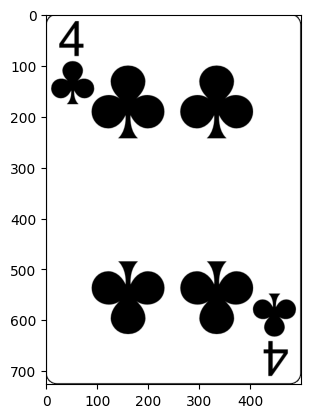

In [9]:
card_sample = df.sample(1)["path"].values[0]
card_img = load_img(card_sample)
show_img(card_img)

In [10]:
# card_img.shape

# Card Segmentation

In [11]:
# Card Segmentation
def get_card_contour(image, t_point = 200, t_area = 50000):
    imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _,thresholdImage = cv2.threshold(imageGray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    morphImage = cv2.morphologyEx(thresholdImage, cv2.MORPH_OPEN, np.ones((15, 15), np.uint8))
    cardContours, _ = cv2.findContours(morphImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cardContours = [ contour for contour in cardContours if len(contour) > t_point and cv2.contourArea(contour) > t_area]
    return cardContours

def euc(pt_1, pt_2):
    return np.sqrt( (pt_1[0] - pt_2[0])**2 + (pt_1[1] - pt_2[1])**2 )
    
def crop_cards(cardContours, inputImage):
    result = []
    for contour in cardContours:
        convex = cv2.convexHull(contour) # should be card contour
        eps = 0.1*cv2.arcLength(convex, True)
        approximate_hull = cv2.approxPolyDP(convex, eps, True)
        approximate_hull = np.reshape(approximate_hull, (4,2))

        point_A = approximate_hull[0]
        point_B = approximate_hull[3]
        point_C = approximate_hull[2]
        point_D = approximate_hull[1]

        AD = euc(point_A, point_D)
        BC = euc(point_B, point_C)
        AB = euc(point_A, point_B)
        CD = euc(point_C, point_D)

        maxWidth = max(int(AD), int(BC))
        maxHeight = max(int(AB), int(CD))

        input_points = np.float32([point_A,point_B,point_C,point_D])
        output_points = np.float32([(0,0), (0, maxHeight-1), (maxWidth-1, maxHeight-1), (maxWidth-1, 0)])

        transform = cv2.getPerspectiveTransform(input_points, output_points)
        output = cv2.warpPerspective(inputImage.copy(), transform, (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)

        # rotate card
        if output.shape[0] < output.shape[1]:
            output = cv2.rotate(output, cv2.ROTATE_90_CLOCKWISE)
        result.append(output)

    return result

def get_card_suits(cardResult):
    return [card[:card.shape[0]*1//2, :card.shape[1]*1//2] for card in cardResult]

In [12]:
inputImage = cv2.imread("assets/cards01.jpg")
inputImageRGB = cv2.cvtColor(inputImage, cv2.COLOR_BGR2RGB)
cardContours = get_card_contour(inputImageRGB)

cardResult = crop_cards(cardContours, inputImageRGB)
cardSuits = get_card_suits(cardResult)

# Card Classification

In [13]:
import torchvision.transforms as T
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score

In [14]:
def crop_corner(img):
    return img[:img.shape[0]//2, :img.shape[1]//2]

In [15]:
H = 50
W = 50

train_transform = T.Compose([
    T.ToPILImage(),
    # T.GaussianBlur(5),
    # T.Resize((H, W)),
    T.RandomRotation(degrees=10, fill=255),
    # T.RandomPerspective(distortion_scale=0.2, fill=255),
    T.RandomCrop((330, 220)),
    T.Resize((40, 40)),
    T.ColorJitter(brightness=(0.5, 1), contrast=1, saturation=0.5),
    T.ToTensor(),
    T.Normalize(0.5, 0.5),
])

test_transform = T.Compose([
    T.ToPILImage(),
    # T.GaussianBlur(5),
    T.Resize((40,40)),
    T.ToTensor(),
    T.Normalize(0.5, 0.5),
])

In [16]:
SHAPE = 1600
HIDDEN = 100

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(SHAPE, HIDDEN)
        self.fc2 = nn.Linear(HIDDEN, 52)

    def forward(self, input):
        x = self.pool1(F.relu(self.conv1(input)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        x = x.view(-1, SHAPE)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [17]:
idx2class = df["class"].to_list()
class2idx = {k:v for v, k in enumerate(idx2class)}

In [18]:
class CardDataset(Dataset):
    def __init__(self, df , transform=test_transform):
        self.X = []
        self.Y = []

        for idx, row in df.iterrows():
            y = class2idx[row["class"]]
            path = row["path"]
            img = load_img(path)
            x = crop_corner(img)
            self.X.append(x)
            self.Y.append(y)

        self.transform = transform

    def __getitem__ (self, idx):
        img = self.X[idx]
        x = self.transform(img)
        y = self.Y[idx]
        return x, y
    def __len__(self):
        return len(self.X)

In [19]:
BATCH_SIZE = 52

train_dataset = CardDataset(df, train_transform)
train_dataloader = DataLoader(
    train_dataset, 
    shuffle=True, 
    batch_size=BATCH_SIZE, 
    pin_memory=True
)

test_dataset = CardDataset(test_df, test_transform)
test_dataloader = DataLoader(
    test_dataset, 
    shuffle=False, 
    batch_size=BATCH_SIZE, 
    pin_memory=True
)

In [20]:
LR = 0.0001

model = SimpleNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [21]:
SAVE_PATH = "best_model.pt"

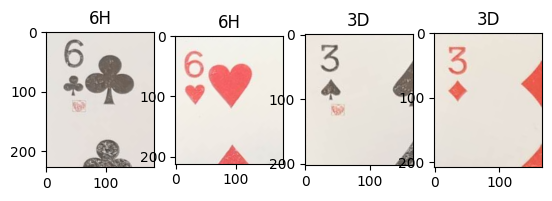

Epoch:500, loss:0.692, test_acc:0.336


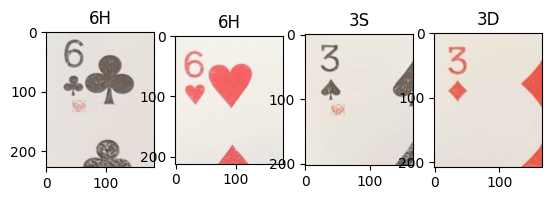

Epoch:1000, loss:0.710, test_acc:0.369


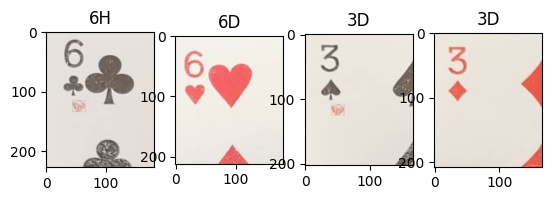

Epoch:1500, loss:0.454, test_acc:0.385


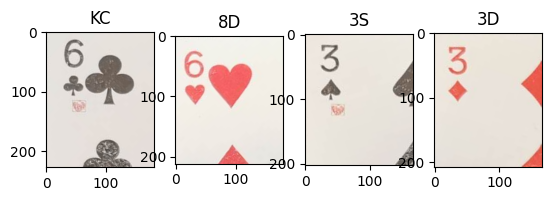

Epoch:2000, loss:0.267, test_acc:0.402


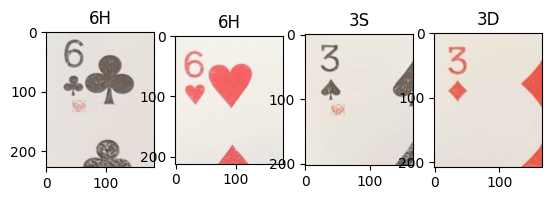

Epoch:2500, loss:0.361, test_acc:0.393


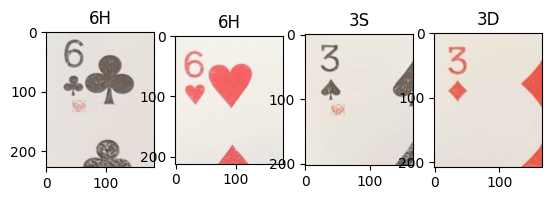

Epoch:3000, loss:0.301, test_acc:0.385


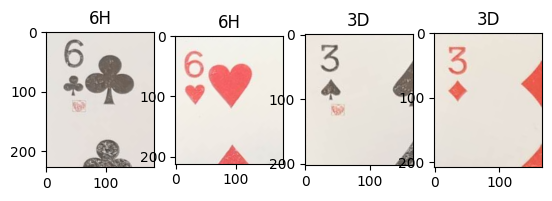

Epoch:3500, loss:0.159, test_acc:0.393


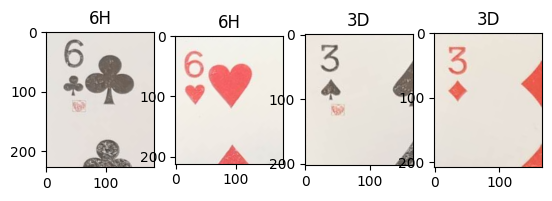

Epoch:4000, loss:0.442, test_acc:0.410


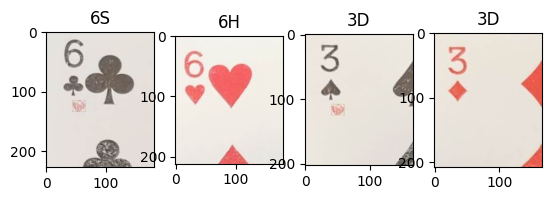

Epoch:4500, loss:0.255, test_acc:0.393


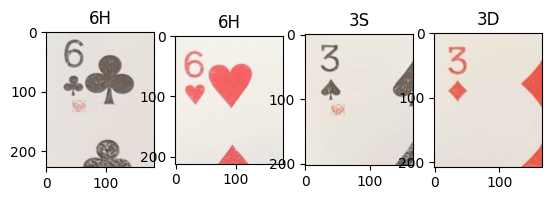

Epoch:5000, loss:0.067, test_acc:0.402


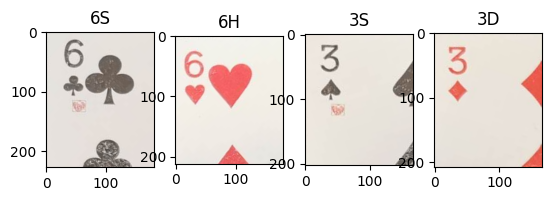

Epoch:5500, loss:0.053, test_acc:0.402


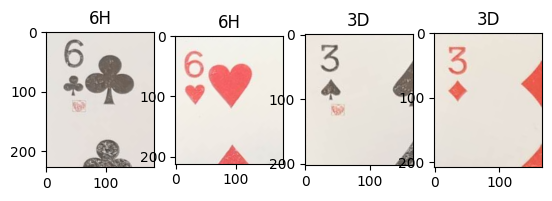

Epoch:6000, loss:0.170, test_acc:0.402


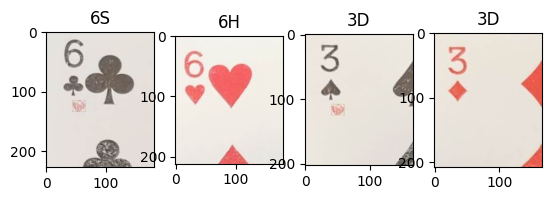

Epoch:6500, loss:0.175, test_acc:0.402


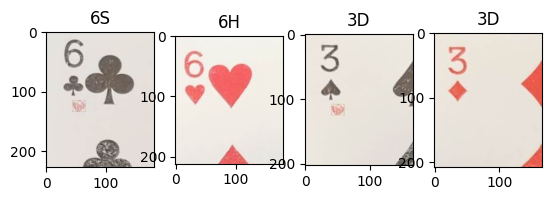

Epoch:7000, loss:0.200, test_acc:0.402


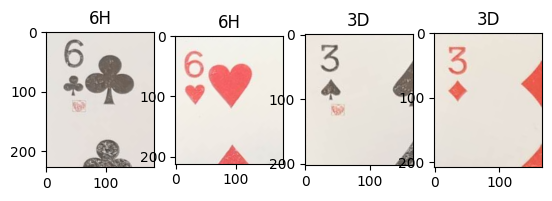

Epoch:7500, loss:0.099, test_acc:0.402


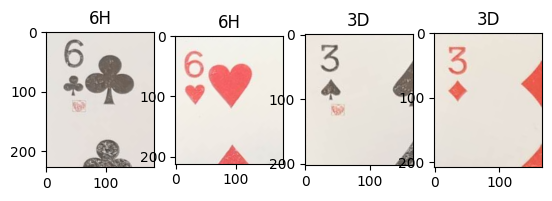

Epoch:8000, loss:0.080, test_acc:0.410


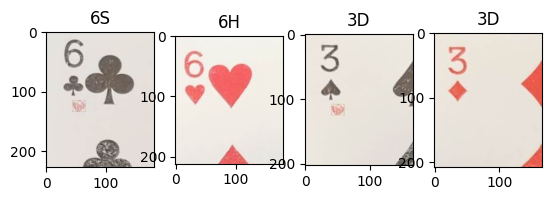

Epoch:8500, loss:0.171, test_acc:0.410


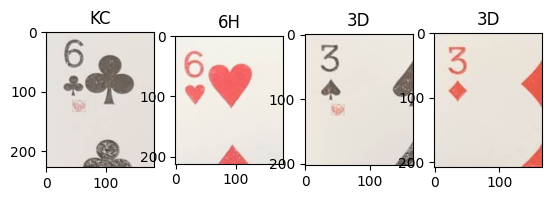

Epoch:9000, loss:0.028, test_acc:0.385


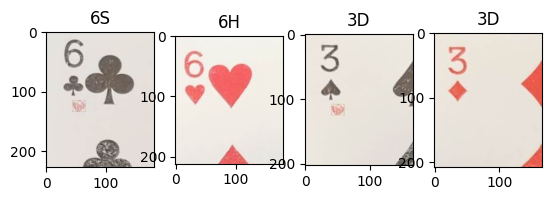

Epoch:9500, loss:0.017, test_acc:0.393


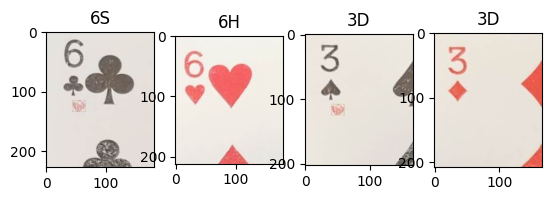

Epoch:10000, loss:0.050, test_acc:0.402


In [22]:
NUM_EPOCH = 10000

best_acc = 0

for e in range(1, NUM_EPOCH+1):
    
    train_losses = []
    
    model.train()
    for x, y in train_dataloader:
        optimizer.zero_grad()
        
        x = x.cuda()
        y = y.cuda()

        pred = model(x)

        loss = criterion(pred, y)

        loss.backward()

        optimizer.step()

        train_losses.append(loss.item())
    
    if e % 100 == 0:
        model.eval()
        y_true = []
        y_pred = []
        for x, y in test_dataloader:
            x = x.cuda()
            y = y.cuda()

            with torch.no_grad():
                pred = model(x)
                pred_y = pred.argmax(axis=1)
            
            y_true.append(y.cpu().numpy())
            y_pred.append(pred_y.cpu().numpy())

        y_true = np.concatenate(y_true).reshape(-1)
        y_pred = np.concatenate(y_pred).reshape(-1)
            
        acc = accuracy_score(y_true, y_pred)

        if acc > best_acc:
                best_acc = acc
                torch.save(model.state_dict(), SAVE_PATH)
    
    # Eval.
    if e % 500 == 0:
        model.eval()
        for i in range(len(cardSuits)):
            plt.subplot(1, len(cardSuits), i+1)
            card = cardSuits[i]
            card_tensor = test_transform(card).cuda()
            with torch.no_grad():
                pred = model(card_tensor)
            result = pred.argmax().cpu().item()
            plt.title(idx2class[result])
            plt.imshow(cardSuits[i])
        plt.show()
        
        print(f"Epoch:{e}, loss:{np.mean(train_losses):.3f}, test_acc:{acc:.3f}")

In [27]:
y_true = []
y_pred = []

model.eval()
for x, y in test_dataloader:
    x = x.cuda()
    y = y.cuda()

    with torch.no_grad():
        pred = model(x)
        pred_y = pred.argmax(axis=1)
    
    y_true.append(y.cpu().numpy())
    y_pred.append(pred_y.cpu().numpy())

y_true = np.concatenate(y_true).reshape(-1)
y_pred = np.concatenate(y_pred).reshape(-1)
    
acc = accuracy_score(y_true, y_pred)
print(acc)

0.4016393442622951


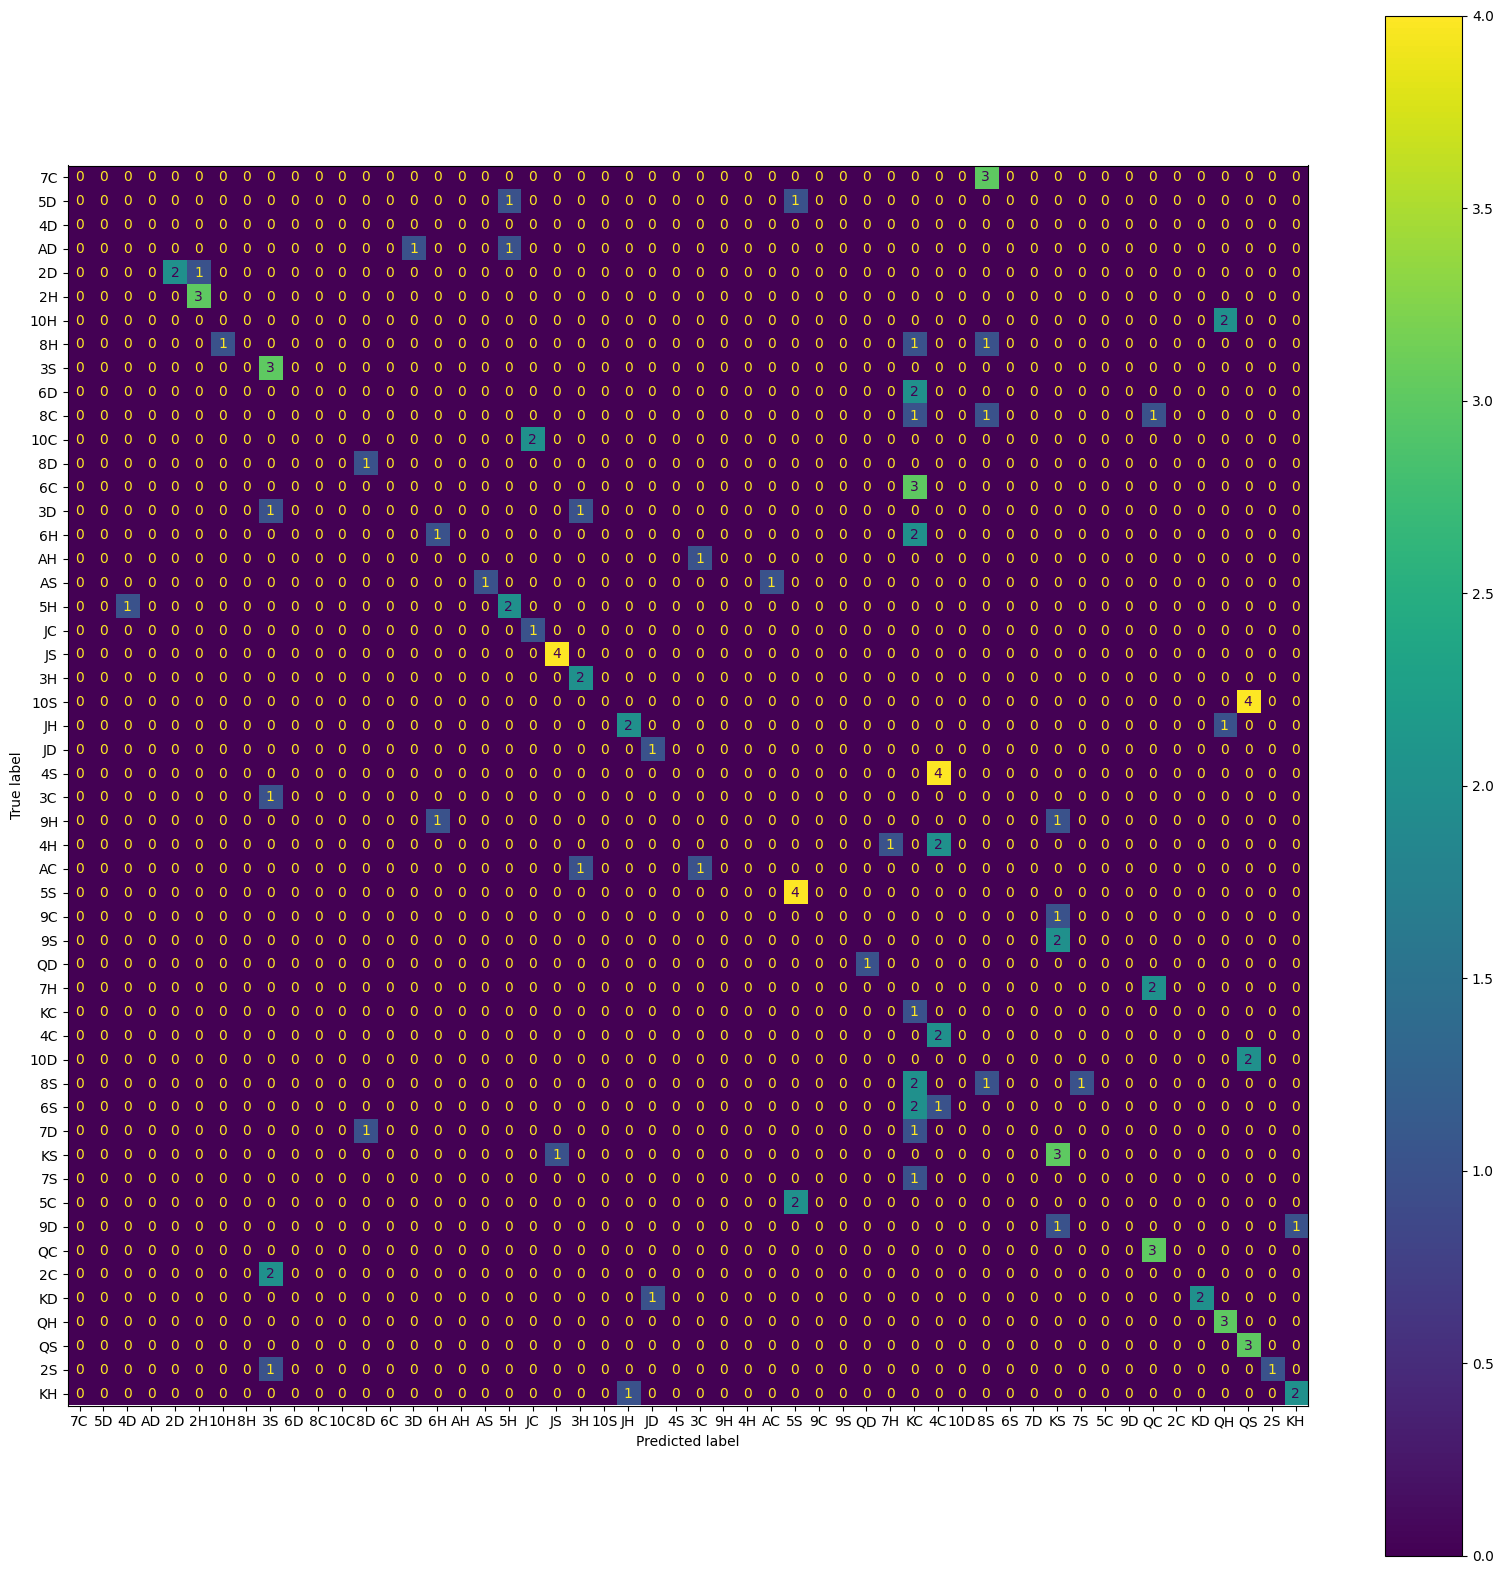

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=idx2class)
fig, ax = plt.subplots(figsize=(20,20))
disp.plot(ax=ax)
plt.show()

In [49]:
class_true = [idx2class[y] for y in y_true]
class_pred = [idx2class[y] for y in y_pred]


num_true = []
suit_true = []
for c in class_true:
    num = c[:-1]
    suit = c[-1]
    num_true.append(num)
    suit_true.append(suit)

num_pred = []
suit_pred = []
for c in class_pred:
    num = c[:-1]
    suit = c[-1]
    num_pred.append(num)
    suit_pred.append(suit)

num_labels = list(set(num_true + num_pred))
suit_labels = list(set(suit_true+suit_pred))

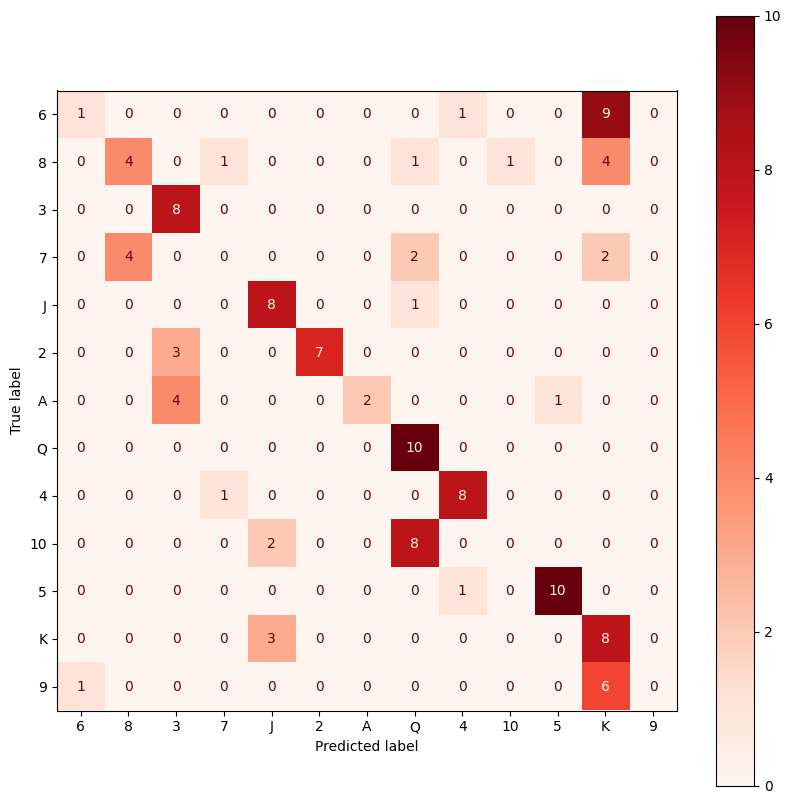

In [54]:
cm = confusion_matrix(np.array(num_true), np.array(num_pred), labels=num_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=num_labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap="Reds")
plt.show()

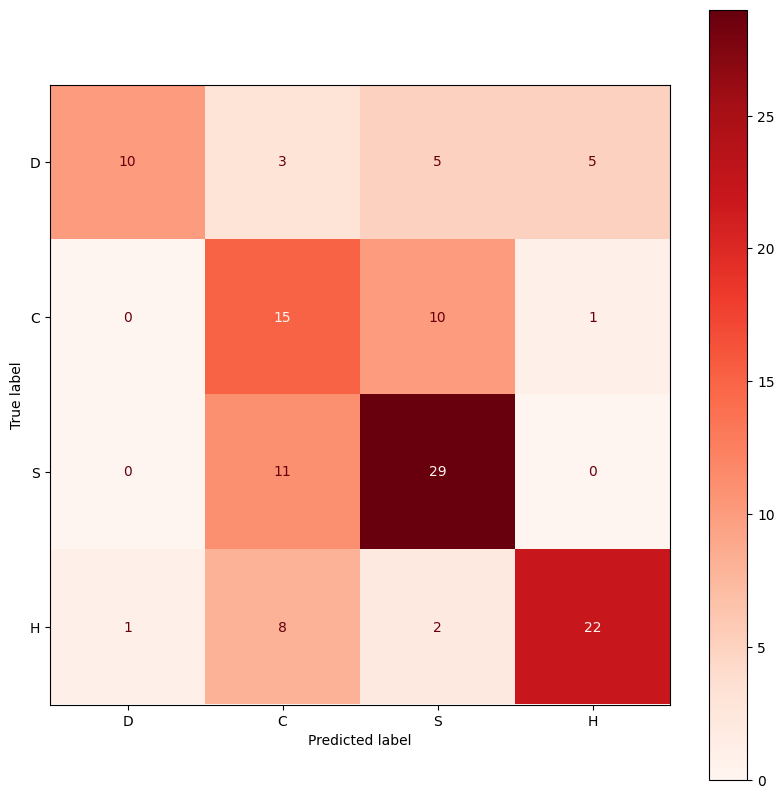

In [58]:
cm = confusion_matrix(np.array(suit_true), np.array(suit_pred), labels=suit_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=suit_labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap="Reds")
plt.show()

## Result

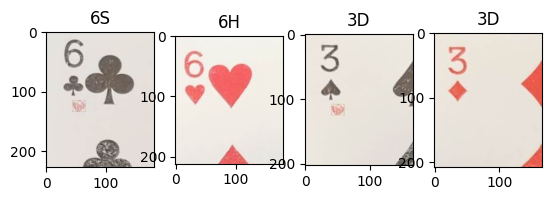

In [25]:
for i in range(len(cardSuits)):
    plt.subplot(1, len(cardSuits), i+1)
    card = cardSuits[i]
    card_tensor = test_transform(card).cuda()
    model.eval()
    with torch.no_grad():
        pred = model(card_tensor)
    result = pred.argmax().cpu().item()
    plt.title(idx2class[result])
    plt.imshow(cardSuits[i])


In [26]:
print(idx2class)

['7C', '5D', '4D', 'AD', '2D', '2H', '10H', '8H', '3S', '6D', '8C', '10C', '8D', '6C', '3D', '6H', 'AH', 'AS', '5H', 'JC', 'JS', '3H', '10S', 'JH', 'JD', '4S', '3C', '9H', '4H', 'AC', '5S', '9C', '9S', 'QD', '7H', 'KC', '4C', '10D', '8S', '6S', '7D', 'KS', '7S', '5C', '9D', 'QC', '2C', 'KD', 'QH', 'QS', '2S', 'KH']
